# models to build

- linear model
- linear mixed effects model
- linear hierarchical model
- linear mixed effects hierarchical model with neural network

# notes
- plop in the neural net
- edward is awesome?
- we're super flexible in all directions with edward, keras

# import data

In [ ]:
import edward as ed
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

In [ ]:
import tensorflow as tf

In [ ]:
from edward.models import Normal

In [ ]:
properties_df = pd.read_csv('data/properties.csv', low_memory=False)
transactions_df = pd.read_csv('data/transactions.csv')

In [ ]:
properties_df = properties_df.rename(columns={
    'parcelid': 'id_parcel',
    'yearbuilt': 'build_year',
    'basementsqft': 'area_basement',
    'yardbuildingsqft17': 'area_patio',
    'yardbuildingsqft26': 'area_shed',
    'poolsizesum': 'area_pool',
    'lotsizesquarefeet': 'area_lot',
    'garagetotalsqft': 'area_garage',
    'finishedfloor1squarefeet': 'area_firstfloor_finished',
    'calculatedfinishedsquarefeet': 'area_total_calc',
    'finishedsquarefeet6': 'area_base',
    'finishedsquarefeet12': 'area_live_finished',
    'finishedsquarefeet13': 'area_liveperi_finished',
    'finishedsquarefeet15': 'area_total_finished',
    'finishedsquarefeet50': 'area_unknown',
    'unitcnt': 'num_unit',
    'numberofstories': 'num_story',
    'roomcnt': 'num_room',
    'bathroomcnt': 'num_bathroom',
    'bedroomcnt': 'num_bedroom',
    'calculatedbathnbr': 'num_bathroom_calc',
    'fullbathcnt': 'num_bath',
    'threequarterbathnbr': 'num_75_bath',
    'fireplacecnt': 'num_fireplace',
    'poolcnt': 'num_pool',
    'garagecarcnt': 'num_garage',
    'regionidcounty': 'region_county',
    'regionidcity': 'region_city',
    'regionidzip': 'region_zip',
    'regionidneighborhood': 'region_neighbor',
    'taxvaluedollarcnt': 'tax_total',
    'structuretaxvaluedollarcnt': 'tax_building',
    'landtaxvaluedollarcnt': 'tax_land',
    'taxamount': 'tax_property',
    'assessmentyear': 'tax_year',
    'taxdelinquencyflag': 'tax_delinquency',
    'taxdelinquencyyear': 'tax_delinquency_year',
    'propertyzoningdesc': 'zoning_property',
    'propertylandusetypeid': 'zoning_landuse',
    'propertycountylandusecode': 'zoning_landuse_county',
    'fireplaceflag': 'flag_fireplace',
    'hashottuborspa': 'flag_tub',
    'buildingqualitytypeid': 'quality',
    'buildingclasstypeid': 'framing',
    'typeconstructiontypeid': 'material',
    'decktypeid': 'deck',
    'storytypeid': 'story',
    'heatingorsystemtypeid': 'heating',
    'airconditioningtypeid': 'aircon',
    'architecturalstyletypeid': 'architectural_style'
})

In [6]:
transactions_df = transactions_df.rename(columns={
  'parcelid': 'id_parcel',
  'transactiondate': 'date'
})

In [7]:
train_df = transactions_df.merge(properties_df, how='left', left_on='id_parcel', right_on='id_parcel')
train_df[['year', 'month', 'day']] = train_df['date'].str.split('-', expand=True)

## drop columns that are too null

In [8]:
keep_cols = train_df.columns[ train_df.isnull().mean() < .25 ]
train_df = train_df[keep_cols]

# inspect data

In [9]:
%matplotlib inline

## which columns are most correlated with target?

In [10]:
float_cols = [col for col in train_df.columns if train_df[col].dtype == np.float64]

In [11]:
train_df[float_cols].corr()['logerror'].abs().sort_values(ascending=False).head(10)

logerror               1.000000
area_live_finished     0.041922
area_total_calc        0.038784
num_bathroom_calc      0.029448
num_bath               0.028845
num_bathroom           0.027889
num_bedroom            0.025467
tax_building           0.022085
build_year             0.017312
censustractandblock    0.008892
Name: logerror, dtype: float64

In [12]:
fixed_effects = ['area_live_finished', 'num_bathroom', 'build_year']

# for now, drop rows with null values

In [14]:
train_df.dropna(inplace=True)

# split into train, validation

In [18]:
X_train, X_val, y_train, y_val = train_test_split(train_df, train_df['logerror'], test_size=0.5, random_state=42)

# build simple linear model

In [20]:
D = 1
N = len(X_train)

In [100]:
area_live_finished = tf.placeholder(tf.float32, [N, D])
β_area_live_finished = Normal(loc=tf.zeros(D), scale=tf.ones(D))
α = Normal(loc=tf.zeros(1), scale=tf.ones(1))
y = Normal(loc=ed.dot(area_live_finished, β_area_live_finished) + α, scale=tf.ones(N))

In [92]:
# `log(exp(features) + 1)`

In [102]:
qβ_area_live_finished = Normal(loc=tf.Variable(tf.random_normal([D])),
            scale=tf.nn.softplus(tf.Variable(tf.random_normal([D]))))
qα = Normal(loc=tf.Variable(tf.random_normal([1])),
            scale=tf.nn.softplus(tf.Variable(tf.random_normal([1]))))

In [103]:
inference = ed.KLqp({β_area_live_finished: qβ_area_live_finished, α: qα}, data={area_live_finished: X_train['area_live_finished'].values.reshape(-1, 1), y: y_train.values})
inference.run(n_samples=5, n_iter=250)

250/250 [100%] ██████████████████████████████ Elapsed: 7s | Loss: 1336646528.000


In [104]:
y_post = ed.copy(y, {β_area_live_finished: qβ_area_live_finished, α: qα})

In [105]:
print("Mean squared error on test data:")
print(ed.evaluate('mean_squared_error', data={area_live_finished: X_val['area_live_finished'].values.reshape(-1, 1), y_post: y_val.values}))

print("Mean absolute error on test data:")
print(ed.evaluate('mean_absolute_error', data={area_live_finished: X_val['area_live_finished'].values.reshape(-1, 1), y_post: y_val.values}))

Mean squared error on test data:
267.849
Mean absolute error on test data:
1.36922


In [106]:
# def visualise(X_data, y_data, α, β_area_live_finished, n_samples=10):
#     β_area_live_finished_samples = β_area_live_finished.sample(n_samples).eval()
#     α_samples = α.sample(n_samples).eval()
#     plt.scatter(X_data['area_live_finished'], y_data)
#     inputs = np.linspace(0, 18000, num=100000)
#     for ns in range(n_samples):
#         output = α_samples[ns] + inputs * β_area_live_finished_samples[ns]
#         plt.plot(inputs, output)

def visualise(X_data, y_data, w, b, n_samples=10):
  w_samples = w.sample(n_samples)[:, 0].eval()
  b_samples = b.sample(n_samples).eval()
  plt.scatter(X_data, y_data)
  plt.ylim([-50000, 50000])
  inputs = np.linspace(0, 16000, num=16000)
  for ns in range(n_samples):
    output = inputs * w_samples[ns] + b_samples[ns]
    plt.plot(inputs, output)

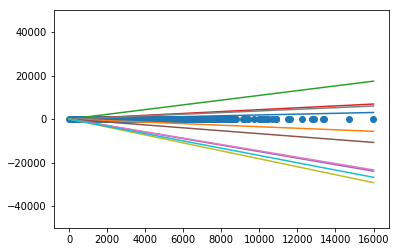

In [107]:
# Visualize samples from the prior.
visualise(X_train['area_live_finished'], y_train, β_area_live_finished, α, n_samples=10)

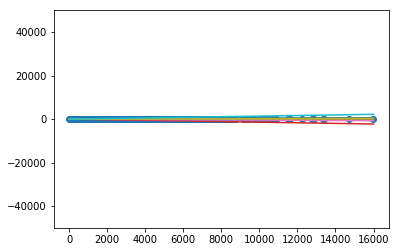

In [109]:
# Visualize samples from the posterior.
visualise(X_train['area_live_finished'], y_train, qβ_area_live_finished, qα, n_samples=10)